# Reading and visualizing a NetCDF file with SURFRAD solar radiation data

*Date: April 29th, 2020*

## Overview
This tutorial will demonstrate how to open and manipulate a NetCDF file from a thredds data server, containing solar radiation data from the BSRN network.

NetCDF is a file format for storing array oriented scientific data, such as solar radiation, temperature or aerosol optical depth. The format has a number of advantages over other common file formats, including the standardized integration of metadata allowing for the data to be self-describin and easy access of a subset of a larger dataset.

## Source data
The data in this tutorial is from the SURFRAD (https://gml.noaa.gov/grad/surfrad/), which is an American network of high quality stations measuring solar and atmospheric radiation. Currently, there are 7 stations in operation, measuring at a minimum: global horizontal irradiance, diffuse horizontal irradiance and direct normal irradiance with a 1 minute time step.

SURFRAD and other data are available as NetCDF files on a thredds server hosted at [webservice-energy.org](http://webservice-energy.org). The naming conventions follow the [climate and forecast conventions](https://www.unidata.ucar.edu/software/netcdf/conventions.html) in order to be interoperable. 

<br>

# 1. Import python modules
***
First import the necessary modules:

In [25]:
import netCDF4 as nc
import datetime as dt
import pandas as pd
import numpy as np
import sg2
import sys
from IPython import display
sys.path.append('./python_functions')

# 2. Visualisation of the content of the TDS server
***

In [20]:
thredds_catalog_url = 'http://tds.webservice-energy.org/thredds/catalog/surfrad-stations/catalog.html'
display.HTML(url=thredds_catalog_url)

Dataset,Size,Last Modified
SURFRAD,,--
SURFRAD-TBL.nc,78.46 Mbytes,2022-04-13T14:09:01.574Z
SURFRAD-SXF.nc,68.77 Mbytes,2022-04-13T14:06:18.985Z
SURFRAD-PSU.nc,72.60 Mbytes,2022-04-13T14:07:31.716Z
SURFRAD-GWN.nc,70.79 Mbytes,2022-04-13T14:08:26.682Z
SURFRAD-FPK.nc,75.06 Mbytes,2022-04-13T14:09:07.633Z
SURFRAD-DRA.nc,77.04 Mbytes,2022-04-13T14:08:24.163Z
SURFRAD-BON.nc,70.71 Mbytes,2022-04-13T14:08:32.172Z


<br>

# 2. Read NetCDF file
***
As an example, the data from the BSRN station Payern is downloaded from the thredds server using the *netCDF4* Python library.

In [21]:
%%time
ID='BON'
thredds_url = 'http://tds.webservice-energy.org/thredds/dodsC/surfrad-stations/'
filename = 'SURFRAD-{}.nc'.format(ID) # filename for the specific measurements station

data_nc = nc.Dataset("[FillMismatch]"+thredds_url+filename) # open the NetCDF file from the server (without downloading the data!)
print(data_nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    description: Archive of solar radiation networks worldwide provided by the Webservice-Energy initiative supported by MINES Paris PSL. Files are provided as NetCDF file format with the support of a Thredds Data Server.
    title: Timeseries of NOAA's Surface Radiation Budget Network (SURFRAD) (SURFRAD)
    keywords: meteorology, station, time, Earth Science > Atmosphere > Atmospheric Radiation > Incoming Solar Radiation, Earth Science > Atmosphere > Atmospheric Temperature > Surface Temperature > Air Temperature, Earth Science > Atmosphere > Atmospheric Pressure > Sea Level Pressure
    keywords_vocabulary: GCMD Science Keywords
    keywords_vocabulary_url: https://gcmd.earthdata.nasa.gov/static/kms/
    contact: Lionel MENARD, Raphael JOLIVET, Yves-Marie SAINT-DRENAN, Philippe BLANC
    institution:  MINES Paris PSL
    record: Basic measurements (global irradiance, direct irradiance, diff

<br>

The NetCDF file contains a number of variables:

In [11]:
data_nc.variables.keys()

dict_keys(['station_name', 'latitude', 'longitude', 'elevation', 'Time', 'GHI', 'DHI', 'BNI', 'T2', 'WS', 'WD'])

<br>
Each variable contains metadata describing the variable. For example, for the variable GHI, the metadata gives the fullname (Global Horizontal Irradiance), the unit (W/m$^2$) and gives a comment that "GHI is set to 0 for SZA >= 97 deg".

In [12]:
data_nc.variables['GHI']

<class 'netCDF4._netCDF4.Variable'>
float32 GHI(time)
    parameter: Short-wave downward (GLOBAL) radiation
    long_name: Global Horizontal Irradiance
    standard_name: surface_downwelling_shortwave_flux_in_air
    abbreviation: SWD
    units: W m-2
    Range_LowerBoundary: -10.0
    Range_UpperBoundary: 3000
    Description: global, mean
    least_significant_digit: 1
    FirstData: 1997-05-11T00:00
    LastData: 2022-02-27T23:59
    _ChunkSizes: 1024
unlimited dimensions: time
current shape = (14284800,)
filling off

<br>

Furthermore, this dataset contains three variables related to the location of the BSRN station: latitude, longitude and elevation.

In [13]:
lat  = data_nc.variables['latitude'][:].data
lon  = data_nc.variables['longitude'][:].data
elev = data_nc.variables['elevation'][:].data
print('Latitude = {}°N\nLongitude = {}°E\nElevation = {} m'.format(lat, lon, elev))

Latitude = 40.04999923706055°N
Longitude = -88.37000274658203°E
Elevation = 213.0 m


<br>
Next, the time series data is extracted and saved to individual variables. For demonstration purposes, only measurement data for the first three years are extracted.

In [17]:
%%time

# loading and conversion of the time vector 
time0=data_nc.variables['Time'][:].data
time=pd.to_datetime(time0, unit='s',origin=pd.Timestamp('1997-05-11'))

# download measurements of the three components of the solar irradiance
GHI = data_nc.variables['GHI'][:].data
DHI = data_nc.variables['DHI'][:].data
BNI = data_nc.variables['BNI'][:].data

GHI[GHI>9999999]=np.nan
DHI[DHI>9999999]=np.nan
BNI[BNI>9999999]=np.nan


Wall time: 13.1 s


In [39]:
df = pd.DataFrame({'GHI': GHI,'BNI': BNI,'DHI':DHI}, index=time)

df.head()


,GHI,BNI,DHI
1997-05-11 00:00:00,NaN,NaN,NaN
1997-05-11 00:01:00,NaN,NaN,NaN
1997-05-11 00:02:00,NaN,NaN,NaN
1997-05-11 00:03:00,NaN,NaN,NaN
1997-05-11 00:04:00,NaN,NaN,NaN


# 3: Calculation of sun position
***

In this tutorial, the sun position will be calculated using the wps_SG2 webservice available through the python package *solargeometry*. A request is sent to the webservice, which carries out the calculations and returns the results. For longer time series, this method is significantly faster than calculating the sun position locally using, for example, the pvlib-python library.


output
    The output is a python list of fields identified by python strings.  Each
    given fields will be computed and provided in the output o as follow :
    *"field.name"* will be *o.field.name*.  Possible fields and there output
    type are:

    * "geoc.ut" **timestamp** as array of datetime64[ms]
    * "geoc.tt" **terrestrial time** as array of datetime64[ms]
    * "geoc.R" **Radius Sun-Earth** in astronomical unit (au) as array of double
    * "geoc.L" **Heliocentric Earth true longitude** in radians as array of double
    * "geoc.delta" **Geocentric declination** in radians as array of double
    * "geoc.EOT" **Equation of Time: difference between apparent solar time and mean solar time** in radians as array of double (to be multiplied by pi/12 for hourly values)
    * "geoc.Theta_a" **Geocentric Earth true longitude** in radians as array of double
    * "geoc.epsilon" **Earth true obliquity** in radians as array of double
    * "geoc.nu" **Apparent sideral time** in radians as array of double
    * "geoc.r_alpha" **Geocentric right ascension** in radians as array of double
    * "geoc.Delta_psi" **Nutation in Geocentric Sun longitude** in radians as array of double
    * "gp.lambda" **Longitude** in radians as array of double
    * "gp.phi" **Latitude** in radians as array of double
    * "gp.u" **phi geocentric**
    * "gp.x"
    * "gp.y"
    * "topoc.delta" **Topocentric sun declination** in radians as array of double
    * "topoc.alpha_S" **Topocentric sun azimuth** in radians as array of double
    * "topoc.gamma_S0" **Topocentric sun elevation angle without correction of atm. refraction.** in radians as array of double
    * "topoc.omega" **Topocentric local hour angle** in radians as array of double
    * "topoc.r_alpha" **Topocentric right sun ascension** in radians as array of double
    * "topoc.toa_hi" **Top of atmosphere horizontal irradiance** in W.m^{-2} as array of double
    * "topoc.toa_ni" **Top of atmosphere normal irradiance** in W.m^{-2} as array of double

    The abreviations geoc and topoc stand for respectively geocentric and topocentric.

    Moreover the size of arrays of geoc.* fields will be (M,), the size of
    arrays of gp.* fields will be (N,) and the size of arrays of topoc.* will
    be (N,M).


This library can be installed via pip:  "pip install sg2 -f https://pip.oie-lab.net/python-devel/ "


In [44]:
%%time

gp = [lat, lon, elev]

p = sg2.sun_position([gp], df.index.values,
                     ["geoc.EOT",
                      "topoc.omega",
                      "topoc.gamma_S0",
                      "topoc.alpha_S",
                      "topoc.delta",
                      "topoc.r_alpha",
                      "topoc.toa_hi",
                      "topoc.toa_ni"])
print(p)

namespace(geoc=namespace(EOT=array([106.83002417, 106.83002426, 106.83002436, ..., 276.43783949,
       276.43783902, 276.43783855])), gp=namespace(), topoc=namespace(alpha_S=array([[2.42048889, 2.41609503, 2.41170131, ..., 2.47052896, 2.46612528,
        2.46172175]]), delta=array([[0.3112838 , 0.31128692, 0.31129004, ..., 0.39168018, 0.39167878,
        0.39167738]]), gamma_S0=array([[-0.33271033, -0.3326313 , -0.33255187, ..., -0.41402712,
        -0.41394834, -0.41386913]]), omega=array([[ 39946.0654501 ,  39946.06981351,  39946.07417692, ...,
        102444.85840095, 102444.8627638 , 102444.86712665]]), r_alpha=array([[0.83617613, 0.83618798, 0.83619984, ..., 1.88003262, 1.88004504,
        1.88005746]]), toa_hi=array([[0., 0., 0., ..., 0., 0., 0.]]), toa_ni=array([[0., 0., 0., ..., 0., 0., 0.]])))
Wall time: 7.81 s


Calcul des heures de lever et de coucher de soleil avec la librairie sg2.


def sun_rise(ggeopoint, timestamp)
- input geopoints: (N,3) of double each row is lon in degrees, lat in degrees, altitude in metter.
  - input timespamp: (M,) of double or datetime64. the requested timestamp in ut
  - output: (N,M,3) datetime64[ms] with repectively sun rise, sun transit and
sun set in ut.
 

In [42]:
SR=sg2.sun_rise([gp], df.index.values)


(14284800,)

In [37]:
df = pd.DataFrame({'GHI': GHI,'BNI': BNI,'DHI':DHI}, index=time)
p


print(SR.shape)
#SG2

'''
SR_h 	SS_h
tzinfo = pytz.timezone('utc')

date_begin = dt.datetime(time.min().year, 1, 1, 0, 0, tzinfo=tzinfo)
date_end = dt.datetime(time.max().year, 12, 31, 23, 59, tzinfo=tzinfo)



SG2 = wps.wps_SG2(location, date_begin, date_end, 1/60.)
SG2.head()
'''

(14284800, 1, 3)


"\nSR_h \tSS_h\ntzinfo = pytz.timezone('utc')\n\ndate_begin = dt.datetime(time.min().year, 1, 1, 0, 0, tzinfo=tzinfo)\ndate_end = dt.datetime(time.max().year, 12, 31, 23, 59, tzinfo=tzinfo)\n\n\n\nSG2 = wps.wps_SG2(location, date_begin, date_end, 1/60.)\nSG2.head()\n"


# 4: Merge data into a single Pandas DataFrame and saving data
***

The final step is to combine the BSRN measurement time series and the sun position time series into one Pandas DataFrame.

In [59]:
%%time
df = pd.DataFrame({'GHI': GHI,
                   'BNI': BNI,
                   'DHI':DHI,
                   'DELTA':np.squeeze(p.topoc.delta),
                   'OMEGA':np.squeeze(p.topoc.omega),
                   'EOT':np.squeeze(p.geoc.EOT),
                   'THETA_Z':np.squeeze(np.pi/2-p.topoc.gamma_S0),
                   'GAMMA_S0':np.squeeze(p.topoc.gamma_S0),
                   'ALPHA_S':np.squeeze(p.topoc.alpha_S),
                   'R':np.squeeze(p.topoc.r_alpha),
                   'TOA':np.squeeze(p.topoc.toa_hi),
                   'TOANI':np.squeeze(p.topoc.toa_ni),
                   'SR_h':SR[:,0,0],
                   'SS_h':SR[:,0,2],
                  }, index=time)
df.reindex(pd.date_range(date_begin, date_end, freq='1min', tz='utc'))

df.head()

Wall time: 6.03 s


,GHI,BNI,DHI,DELTA,OMEGA,EOT,THETA_Z,GAMMA_S0,ALPHA_S,R,TOA,TOANI,SR_h,SS_h
1997-05-11 00:00:00,NaN,NaN,NaN,0.311284,39946.065450,106.830024,1.903507,-0.332710,2.420489,0.836176,0.0,0.0,NaT,NaT
1997-05-11 00:01:00,NaN,NaN,NaN,0.311287,39946.069814,106.830024,1.903428,-0.332631,2.416095,0.836188,0.0,0.0,NaT,NaT
1997-05-11 00:02:00,NaN,NaN,NaN,0.311290,39946.074177,106.830024,1.903348,-0.332552,2.411701,0.836200,0.0,0.0,NaT,NaT
1997-05-11 00:03:00,NaN,NaN,NaN,0.311293,39946.078540,106.830024,1.903268,-0.332472,2.407308,0.836212,0.0,0.0,NaT,NaT
1997-05-11 00:04:00,NaN,NaN,NaN,0.311296,39946.082904,106.830025,1.903188,-0.332392,2.402914,0.836224,0.0,0.0,NaT,NaT


<AxesSubplot:>

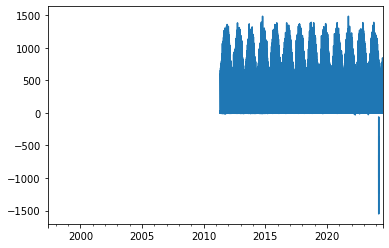

In [60]:
df['GHI'].plot()

<br>
It is possible to save a DataFrame in numerous formats. Here it is shown how to save it as a *Pandas pickle* which we use in the following tutorials.

In [70]:
#%%time
#df.to_pickle('./tmpData/{}_data.pkl'.format(ID)) # save the DataFrame in the Pandas pickle format


# todo: include the name and information of the station in the saved file.

Wall time: 393 ms


<br><br>

***
Once all the data is combined into one DataFrame, manipulation and plotting become relatively easy tasks.

As an example, the first month of the GHI, DHI, and BNI is plotted with the original 1 minute resolution:

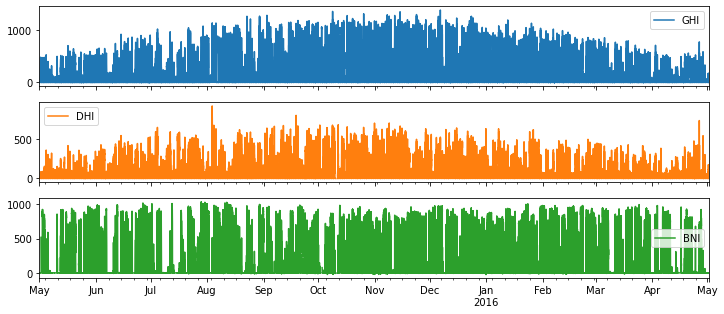

In [61]:
_ = df.loc['2015-05-01':'2016-05-01', ['GHI','DHI','BNI']].plot(figsize=(12,5), subplots=True)

Plotting the monthly average irradiance as a bar chart, can be done in one line as well:

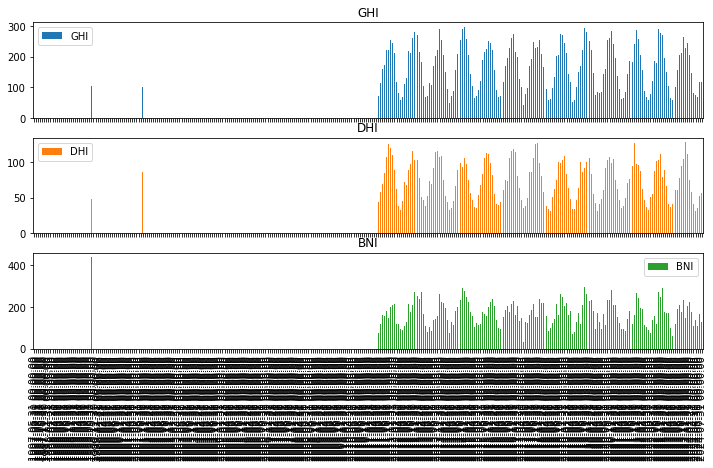

In [62]:
_ = df[['GHI','DHI','BNI']].resample('1M').mean().plot(figsize=(12,6), kind='bar', subplots=True)